In [1]:
import pysal as ps

In [3]:
shp_qw = ps.queen_from_shapefile('input/taz_timestep.shp')

In [5]:
shp_qw.transform = 'r'

In [7]:
import geopandas as gpd
import pandas as pd
shp = gpd.read_file('input/taz_timestep.shp')

In [8]:
shp.head()

,geohash6,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,geometry
0,qp03wc,0.054858,0.086209,0.050739,0.075174,0.062867,0.056765,0.069417,0.079853,0.119192,...,0.212908,0.221505,0.221193,0.254501,0.200325,0.239276,0.244779,0.248946,0.264838,"POLYGON ((90.648193359375 -5.350341796875, 90...."
1,qp03pn,0.000000,0.005546,0.013577,0.004720,0.004425,0.000303,0.013996,0.004471,0.014096,...,0.042419,0.042005,0.036226,0.055335,0.029098,0.047898,0.057352,0.044952,0.042234,"POLYGON ((90.6591796875 -5.4107666015625, 90.6..."
2,qp09sw,0.022881,0.019733,0.023053,0.029018,0.073814,0.066341,0.061355,0.094834,0.086832,...,0.073668,0.088404,0.085995,0.092156,0.131972,0.117505,0.104735,0.104936,0.100530,"POLYGON ((90.90087890625 -5.3228759765625, 90...."
3,qp0991,0.012395,0.048042,0.078544,0.074393,0.117350,0.092151,0.061261,0.083871,0.083997,...,0.074732,0.104935,0.074345,0.163029,0.147321,0.127073,0.133134,0.103328,0.091788,"POLYGON ((90.7470703125 -5.350341796875, 90.75..."
4,qp090q,0.000000,0.000000,0.000000,0.011483,0.003363,0.015389,0.016686,0.017399,0.004562,...,0.033637,0.036047,0.008174,0.016565,0.011225,0.017108,0.032772,0.046205,0.045149,"POLYGON ((90.714111328125 -5.4107666015625, 90..."


In [38]:
import matplotlib.pyplot as plt
%pylab inline

def compare_map(col1, col2):
    fig = plt.figure(figsize=(22,8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    shp.plot(figsize=(10,6), vmax=0.7, column=col1, ax=ax1)
    shp.plot(figsize=(10,6), vmax=0.7, column=col2, ax=ax2)

In [53]:
ts = '200'
values = shp[ts]
lag = ps.lag_spatial(shp_qw, values)
shp[ts+'_lag'] = values + 0.3 * lag

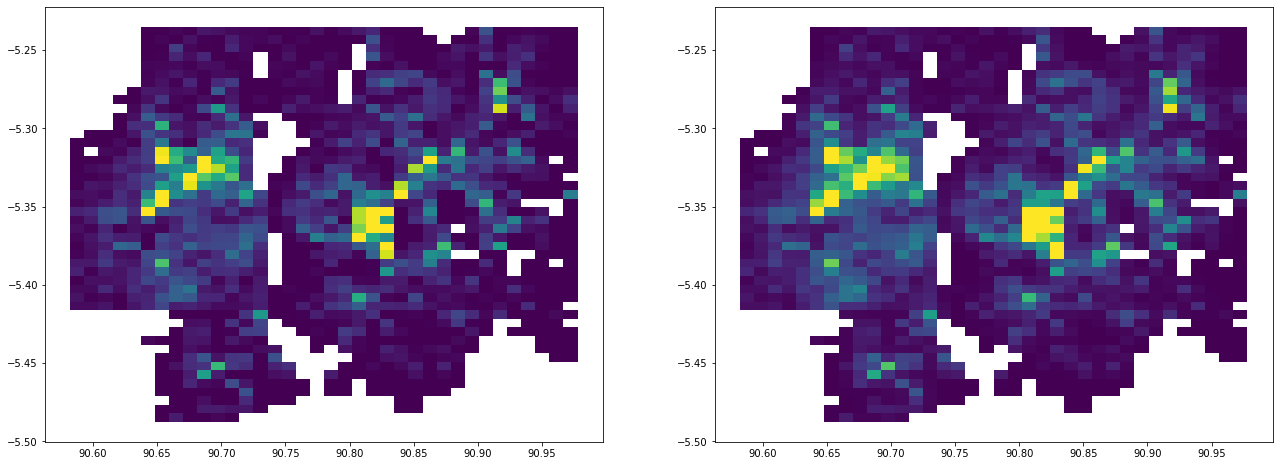

In [54]:
compare_map(ts, ts+'_lag')

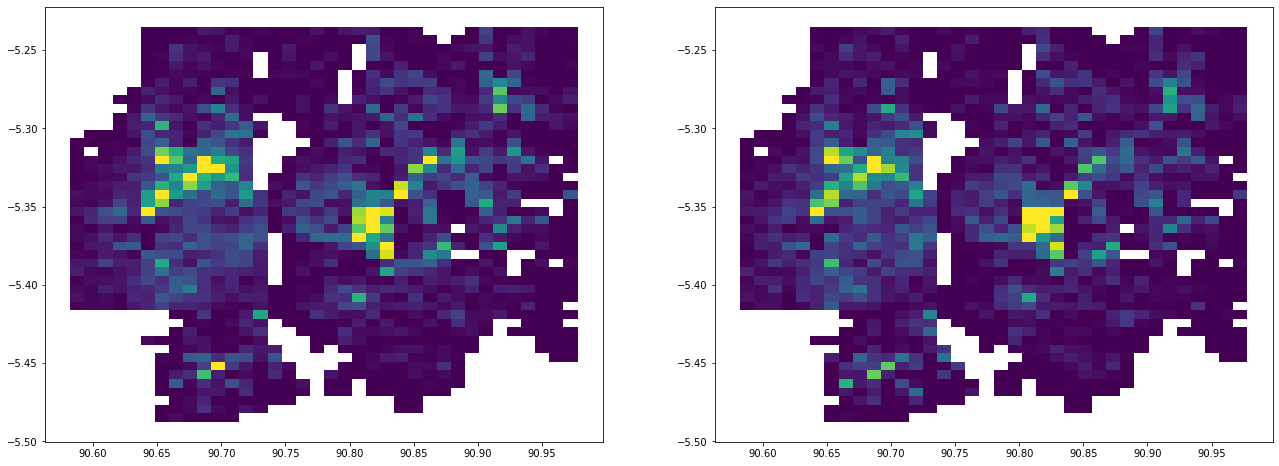

In [55]:
compare_map(str(int(ts)+1), str(int(ts)+4))